In [1]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

%cd '/content/gdrive/MyDrive'


Mounted at /content/gdrive/
/content/gdrive/MyDrive


In [2]:
import pandas as pd
import numpy as np
from collections import defaultdict
import itertools
import matplotlib.pyplot as plt


In [3]:
movies_df=pd.read_csv('./ml-latest-small/movies.csv')
ratings_df=pd.read_csv('./ml-latest-small/ratings.csv')
links_df=pd.read_csv('./ml-latest-small/links.csv')
tags_df=pd.read_csv('./ml-latest-small/tags.csv')

In [4]:
df = pd.merge(movies_df, ratings_df, on='movieId', how='inner')

In [5]:
df

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483
...,...,...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184,4.0,1537109082
100832,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184,3.5,1537109545
100833,193585,Flint (2017),Drama,184,3.5,1537109805
100834,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184,3.5,1537110021


In [6]:
df=df[df['rating']>2.0]
t_data=df.groupby('userId')['title'].agg(list).reset_index()

In [7]:
t_data = t_data[t_data['title'].apply(len) > 10]
t_data

,userId,title
0,1,"[Toy Story (1995), Grumpier Old Men (1995), He..."
1,2,"[Shawshank Redemption, The (1994), Tommy Boy (..."
2,3,"[Escape from L.A. (1996), Highlander (1986), S..."
3,4,"[Get Shorty (1995), To Die For (1995), Mighty ..."
4,5,"[Toy Story (1995), Get Shorty (1995), Babe (19..."
...,...,...
605,606,"[Toy Story (1995), Sabrina (1995), American Pr..."
606,607,"[Toy Story (1995), American President, The (19..."
607,608,"[Toy Story (1995), GoldenEye (1995), Casino (1..."
608,609,"[Toy Story (1995), GoldenEye (1995), Bravehear..."


In [8]:
import random



def create_test_set(user_movies):
    test_set_size = int(0.2 * len(user_movies))
    test_set = random.sample(user_movies, test_set_size)

    training_set = [movie for movie in user_movies if movie not in test_set]

    return training_set, test_set

t_data['training_set'], t_data['test_set'] = zip(*t_data['title'].apply(create_test_set))

train_data = t_data.drop('title', axis=1)


In [9]:
train_data

,userId,training_set,test_set
0,1,"[Toy Story (1995), Heat (1995), Seven (a.k.a. ...","[M*A*S*H (a.k.a. MASH) (1970), Blues Brothers,..."
1,2,"[Shawshank Redemption, The (1994), Tommy Boy (...","[Interstellar (2014), Inside Job (2010), Dark ..."
2,3,"[Escape from L.A. (1996), Highlander (1986), S...","[Hangar 18 (1980), Saturn 3 (1980), Piranha (1..."
3,4,"[To Die For (1995), Mighty Aphrodite (1995), P...","[Waiting for Guffman (1996), Billy Elliot (200..."
4,5,"[Toy Story (1995), Get Shorty (1995), Babe (19...","[Secret Garden, The (1993), Shadowlands (1993)..."
...,...,...,...
605,606,"[Toy Story (1995), Sabrina (1995), Cutthroat I...","[Reservoir Dogs (1992), Ice Age (2002), Braveh..."
606,607,"[Toy Story (1995), American President, The (19...","[Fearless (1993), Saving Private Ryan (1998), ..."
607,608,"[Toy Story (1995), GoldenEye (1995), Casino (1...","[Adventures in Babysitting (1987), Psycho (196..."
608,609,"[Toy Story (1995), GoldenEye (1995), Bravehear...","[Apollo 13 (1995), Pulp Fiction (1994), High S..."


In [42]:
import itertools


class FPNode(object):


    def __init__(self, value, count, parent):

        self.value = value
        self.count = count
        self.parent = parent
        self.link = None
        self.children = []

    def has_child(self, value):

        for node in self.children:
            if node.value == value:
                return True

        return False

    def get_child(self, value):

        for node in self.children:
            if node.value == value:
                return node

        return None

    def add_child(self, value):

        child = FPNode(value, 1, self)
        self.children.append(child)
        return child


class FPTree(object):


    def __init__(self, transactions, threshold, root_value, root_count):

        self.frequent = self.find_frequent_items(transactions, threshold)
        self.headers = self.build_header_table(self.frequent)
        self.root = self.build_fptree(
            transactions, root_value,
            root_count, self.frequent, self.headers)

    @staticmethod
    def find_frequent_items(transactions, threshold):
        items = {}

        for transaction in transactions:
            for item in transaction:
                if item in items:
                    items[item] += 1
                else:
                    items[item] = 1

        for key in list(items.keys()):
            if items[key] < threshold:
                del items[key]

        return items

    @staticmethod
    def build_header_table(frequent):

        headers = {}
        for key in frequent.keys():
            headers[key] = None

        return headers

    def build_fptree(self, transactions, root_value,
                     root_count, frequent, headers):

        root = FPNode(root_value, root_count, None)

        for transaction in transactions:
            sorted_items = [x for x in transaction if x in frequent]
            sorted_items.sort(key=lambda x: frequent[x], reverse=True)
            if len(sorted_items) > 0:
                self.insert_tree(sorted_items, root, headers)

        return root

    def insert_tree(self, items, node, headers):

        first = items[0]
        child = node.get_child(first)
        if child is not None:
            child.count += 1
        else:
            child = node.add_child(first)

            if headers[first] is None:
                headers[first] = child
            else:
                current = headers[first]
                while current.link is not None:
                    current = current.link
                current.link = child

        remaining_items = items[1:]
        if len(remaining_items) > 0:
            self.insert_tree(remaining_items, child, headers)

    def tree_has_single_path(self, node):

        num_children = len(node.children)
        if num_children > 1:
            return False
        elif num_children == 0:
            return True
        else:
            return self.tree_has_single_path(node.children[0])

    def mine_patterns(self, threshold):
        if self.tree_has_single_path(self.root):
            return self.generate_pattern_list()
        else:
            return self.zip_patterns(self.mine_sub_trees(threshold))

    def zip_patterns(self, patterns):

        suffix = self.root.value

        if suffix is not None:
            new_patterns = {}
            for key in patterns.keys():
                new_patterns[tuple(sorted(list(key) + [suffix]))] = patterns[key]

            return new_patterns

        return patterns

    def generate_pattern_list(self):

        patterns = {}
        items = self.frequent.keys()

        if self.root.value is None:
            suffix_value = []
        else:
            suffix_value = [self.root.value]
            patterns[tuple(suffix_value)] = self.root.count

        for i in range(1, len(items) + 1):
            for subset in itertools.combinations(items, i):
                pattern = tuple(sorted(list(subset) + suffix_value))
                patterns[pattern] = \
                    min([self.frequent[x] for x in subset])

        return patterns

    def mine_sub_trees(self, threshold):

        patterns = {}
        mining_order = sorted(self.frequent.keys(),
                              key=lambda x: self.frequent[x])

        for item in mining_order:
            suffixes = []
            conditional_tree_input = []
            node = self.headers[item]
            while node is not None:
                suffixes.append(node)
                node = node.link
            for suffix in suffixes:
                frequency = suffix.count
                path = []
                parent = suffix.parent

                while parent.parent is not None:
                    path.append(parent.value)
                    parent = parent.parent

                for i in range(frequency):
                    conditional_tree_input.append(path)

            subtree = FPTree(conditional_tree_input, threshold,
                             item, self.frequent[item])
            subtree_patterns = subtree.mine_patterns(threshold)

            for pattern in subtree_patterns.keys():
                if pattern in patterns:
                    patterns[pattern] += subtree_patterns[pattern]
                else:
                    patterns[pattern] = subtree_patterns[pattern]

        return patterns


def find_frequent_patterns(transactions, support_threshold):

    tree = FPTree(transactions, support_threshold, None, None)
    return tree.mine_patterns(support_threshold)
def generate_association_rules(patterns, confidence_threshold):
    rules = []
    for itemset in patterns.keys():
        upper_support = patterns[itemset]
        for i in range(1, 2):
            for antecedent in itertools.combinations(itemset, i):
                antecedent = tuple(sorted(antecedent))
                consequent = tuple(sorted(set(itemset) - set(antecedent)))

                if antecedent in patterns and len(consequent)>0:
                    lower_support = patterns[antecedent]
                    confidence = float(upper_support) / lower_support

                    if confidence >= confidence_threshold:
                        rules.append((antecedent,consequent,confidence,upper_support))
    return rules


In [43]:

frequent_itemsets=find_frequent_patterns(train_data['training_set'],50)
association_rules=generate_association_rules(frequent_itemsets,0.1)

In [67]:
association_rules[:20]

[(('Sin City (2005)',), ('Fight Club (1999)',), 0.828125, 53),
 (('Star Wars: Episode II - Attack of the Clones (2002)',),
  ('Star Wars: Episode VI - Return of the Jedi (1983)',),
  0.8333333333333334,
  55),
 (('Big Lebowski, The (1998)',),
  ('Pulp Fiction (1994)',),
  0.7142857142857143,
  50),
 (('Requiem for a Dream (2000)',),
  ('Fight Club (1999)',),
  0.6944444444444444,
  50),
 (('Crimson Tide (1995)',), ('Fugitive, The (1993)',), 0.75, 54),
 (('O Brother, Where Art Thou? (2000)',),
  ('Matrix, The (1999)',),
  0.6986301369863014,
  51),
 (('Harry Potter and the Chamber of Secrets (2002)',),
  ('Harry Potter and the Prisoner of Azkaban (2004)',),
  0.6986301369863014,
  51),
 (('Harry Potter and the Prisoner of Azkaban (2004)',),
  ('Harry Potter and the Chamber of Secrets (2002)',),
  0.6219512195121951,
  51),
 (('Gattaca (1997)',), ('Matrix, The (1999)',), 0.684931506849315, 50),
 (('Heat (1995)',),
  ('Silence of the Lambs, The (1991)',),
  0.7162162162162162,
  53),
 (('

In [45]:
sorted_association_rules_confidence = sorted(association_rules, key=lambda x:x[-2],reverse=True)
sorted_association_rules_support = sorted(association_rules, key=lambda x:x[-1],reverse=True)

In [57]:
sorted_association_rules_confidence[:10]

[(('Star Wars: Episode II - Attack of the Clones (2002)',),
  ('Star Wars: Episode VI - Return of the Jedi (1983)',),
  0.8333333333333334,
  55),
 (('Sin City (2005)',), ('Fight Club (1999)',), 0.828125, 53),
 (('Crimson Tide (1995)',), ('Fugitive, The (1993)',), 0.75, 54),
 (('Sleepless in Seattle (1993)',),
  ('Forrest Gump (1994)',),
  0.7435897435897436,
  58),
 (('Heat (1995)',),
  ('Silence of the Lambs, The (1991)',),
  0.7162162162162162,
  53),
 (('Big Lebowski, The (1998)',),
  ('Pulp Fiction (1994)',),
  0.7142857142857143,
  50),
 (('O Brother, Where Art Thou? (2000)',),
  ('Matrix, The (1999)',),
  0.6986301369863014,
  51),
 (('Harry Potter and the Chamber of Secrets (2002)',),
  ('Harry Potter and the Prisoner of Azkaban (2004)',),
  0.6986301369863014,
  51),
 (('Ghost (1990)',), ('Forrest Gump (1994)',), 0.6973684210526315, 53),
 (('Requiem for a Dream (2000)',),
  ('Fight Club (1999)',),
  0.6944444444444444,
  50)]

In [58]:
sorted_association_rules_support[:10]

[(('Forrest Gump (1994)',),
  ('Shawshank Redemption, The (1994)',),
  0.5652173913043478,
  143),
 (('Shawshank Redemption, The (1994)',),
  ('Forrest Gump (1994)',),
  0.5742971887550201,
  143),
 (('Shawshank Redemption, The (1994)',),
  ('Pulp Fiction (1994)',),
  0.5461847389558233,
  136),
 (('Forrest Gump (1994)',), ('Pulp Fiction (1994)',), 0.5217391304347826, 132),
 (('Shawshank Redemption, The (1994)',),
  ('Silence of the Lambs, The (1991)',),
  0.5220883534136547,
  130),
 (('Forrest Gump (1994)',),
  ('Jurassic Park (1993)',),
  0.45454545454545453,
  115),
 (('Forrest Gump (1994)',), ('Braveheart (1995)',), 0.4505928853754941, 114),
 (('Shawshank Redemption, The (1994)',),
  ('Usual Suspects, The (1995)',),
  0.4497991967871486,
  112),
 (('Forrest Gump (1994)',), ('Matrix, The (1999)',), 0.4426877470355731, 112),
 (('Forrest Gump (1994)',), ('Apollo 13 (1995)',), 0.39920948616600793, 101)]

In [48]:
def save_to_file(file_name,data):
  with open(file_name,'w') as file:
    for i in data:
      file.write(str(i[0])+"=>"+str(i[1])+" "+str(i[2])+" "+str(i[3])+"\n")

save_to_file("top100RulesBySupp.txt",sorted_association_rules_support[:100])
save_to_file("top100RulesByConf.txt",sorted_association_rules_confidence[:100])

In [59]:
common=tuple(set(tuple(sorted_association_rules_confidence[:100])).intersection(set(tuple(sorted_association_rules_support[:100]))))

In [60]:
sorted_common_association_rules_confidence = sorted(common, key=lambda x:x[-2],reverse=True)

In [61]:
sorted_common_association_rules_confidence

[(('Shawshank Redemption, The (1994)',),
  ('Forrest Gump (1994)',),
  0.5742971887550201,
  143),
 (('Forrest Gump (1994)',),
  ('Shawshank Redemption, The (1994)',),
  0.5652173913043478,
  143),
 (('Shawshank Redemption, The (1994)',),
  ('Pulp Fiction (1994)',),
  0.5461847389558233,
  136),
 (('Shawshank Redemption, The (1994)',),
  ('Silence of the Lambs, The (1991)',),
  0.5220883534136547,
  130),
 (('Forrest Gump (1994)',), ('Pulp Fiction (1994)',), 0.5217391304347826, 132),
 (('Forrest Gump (1994)',),
  ('Jurassic Park (1993)',),
  0.45454545454545453,
  115),
 (('Forrest Gump (1994)',), ('Braveheart (1995)',), 0.4505928853754941, 114),
 (('Shawshank Redemption, The (1994)',),
  ('Usual Suspects, The (1995)',),
  0.4497991967871486,
  112),
 (('Forrest Gump (1994)',), ('Matrix, The (1999)',), 0.4426877470355731, 112),
 (('Forrest Gump (1994)',), ('Apollo 13 (1995)',), 0.39920948616600793, 101),
 (('Forrest Gump (1994)',),
  ('Star Wars: Episode IV - A New Hope (1977)',),
  0.

In [63]:
def get_precision_recall(row,rules,k):

  test_set=set(row['test_set'])
  valid_rules=[]
  precision=[]
  recall=[]
  for i in rules:
    if str(i[0][0]) in row['training_set']:
      valid_rules.append(i)


  def get_recommendation(n):
    recommended_set=set()
    for rule in valid_rules[:n]:
      recommended_set=recommended_set.union(set(rule[1]))
    return recommended_set
  for i in range(1,k):
    recommended_set=get_recommendation(i)
    hit_set=test_set.intersection(recommended_set)
    precision.append(len(hit_set)/len(test_set) if len(test_set)>0 else 0)
    recall.append(len(hit_set)/len(recommended_set) if len(recommended_set)>0 else 0 )
  return precision,recall

In [64]:
user=[]
for i,row in train_data.iterrows():
  new_row={}
  new_row['userId']=row['userId']
  new_row['precision'],new_row['recall']=get_precision_recall(row,sorted_common_association_rules_confidence,50)
  user.append(new_row)

In [65]:
pd.DataFrame(user,columns=['userId','precision','recall'])

,userId,precision,recall
0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...
602,606,"[0.004672897196261682, 0.004672897196261682, 0...","[1.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
603,607,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
604,608,"[0.0, 0.0, 0.007462686567164179, 0.00746268656...","[0.0, 0.0, 0.3333333333333333, 0.25, 0.25, 0.4..."
605,609,"[0.14285714285714285, 0.2857142857142857, 0.28...","[1.0, 1.0, 0.6666666666666666, 0.5, 0.4, 0.5, ..."


<ipython-input-66-b45ecd7ac492>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))


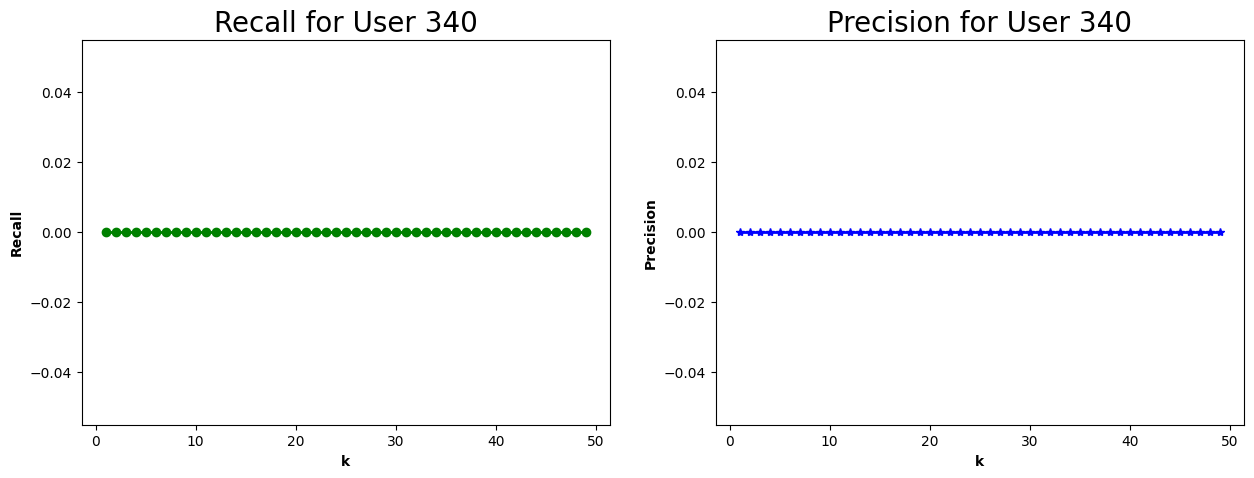

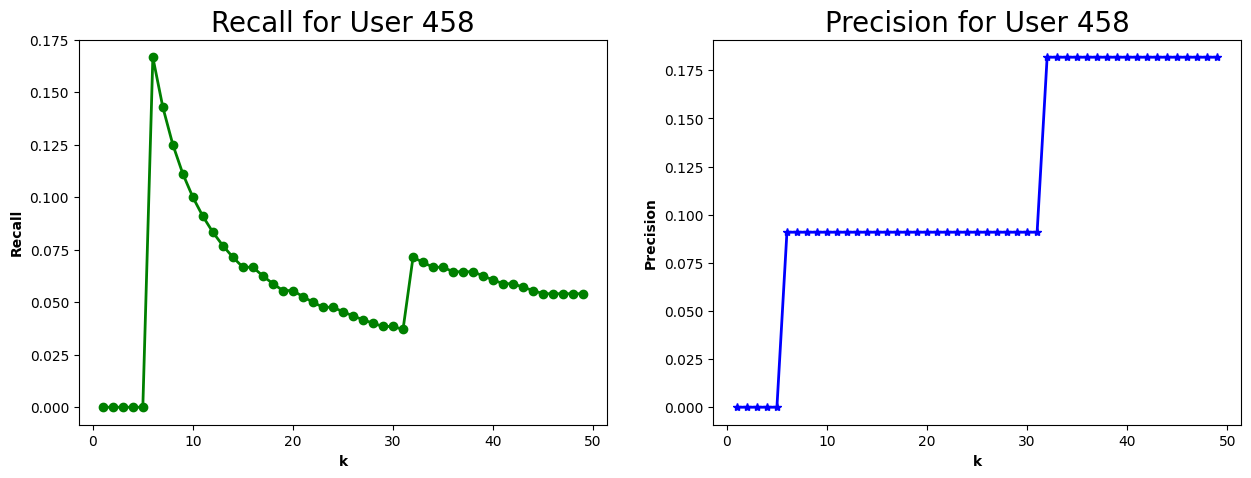

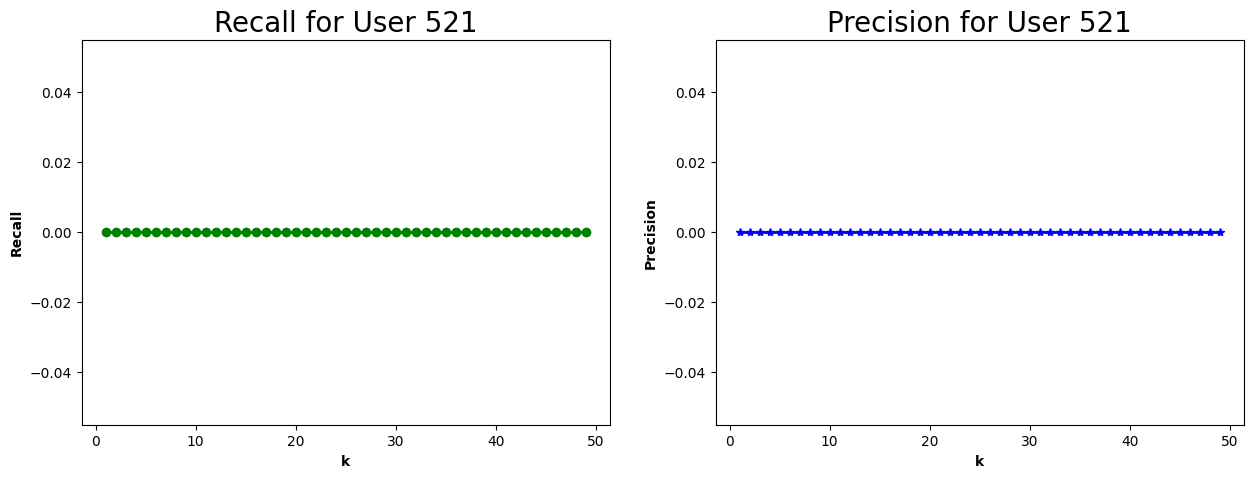

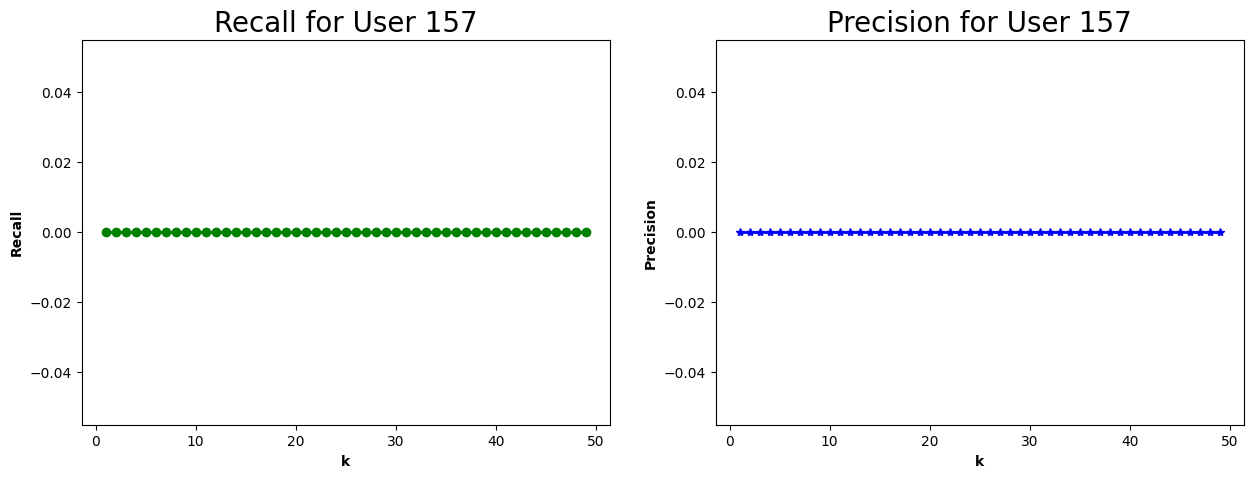

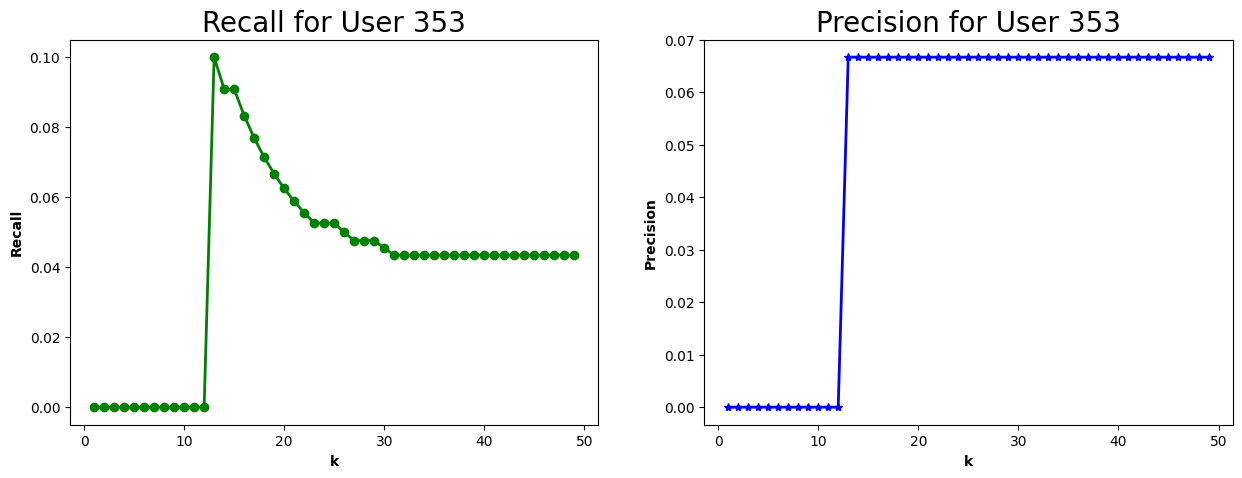

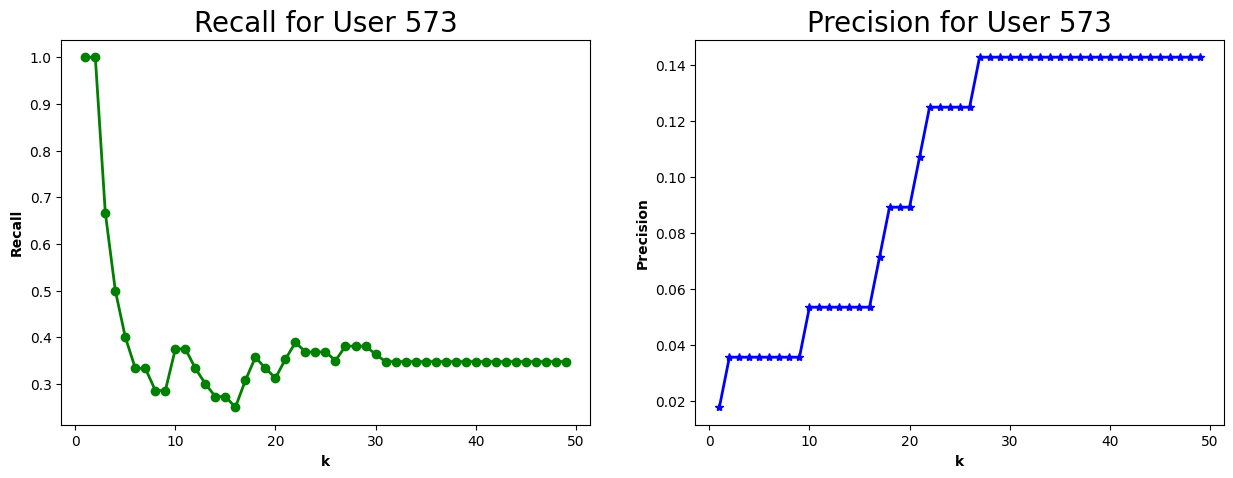

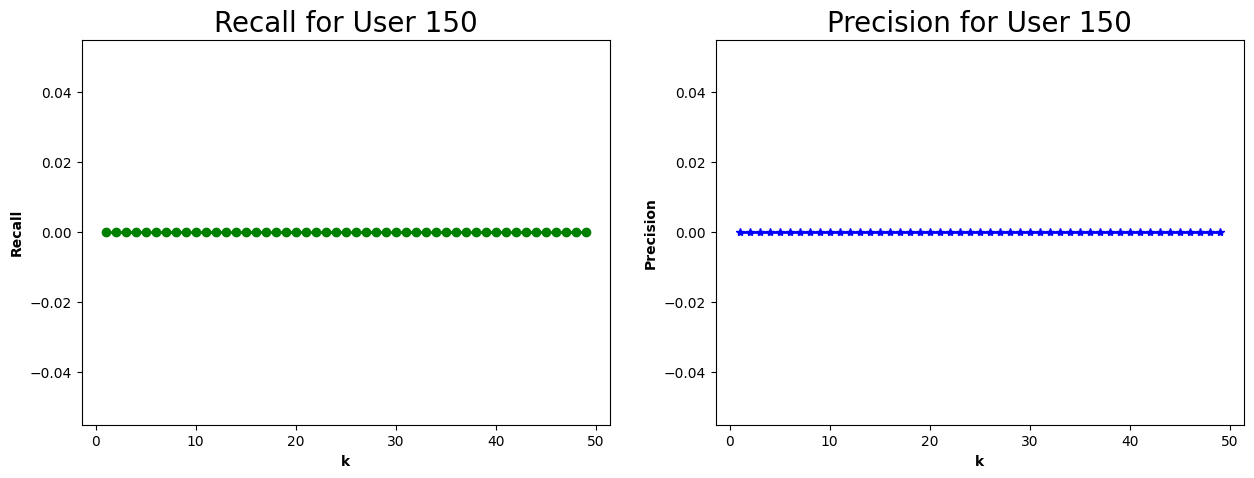

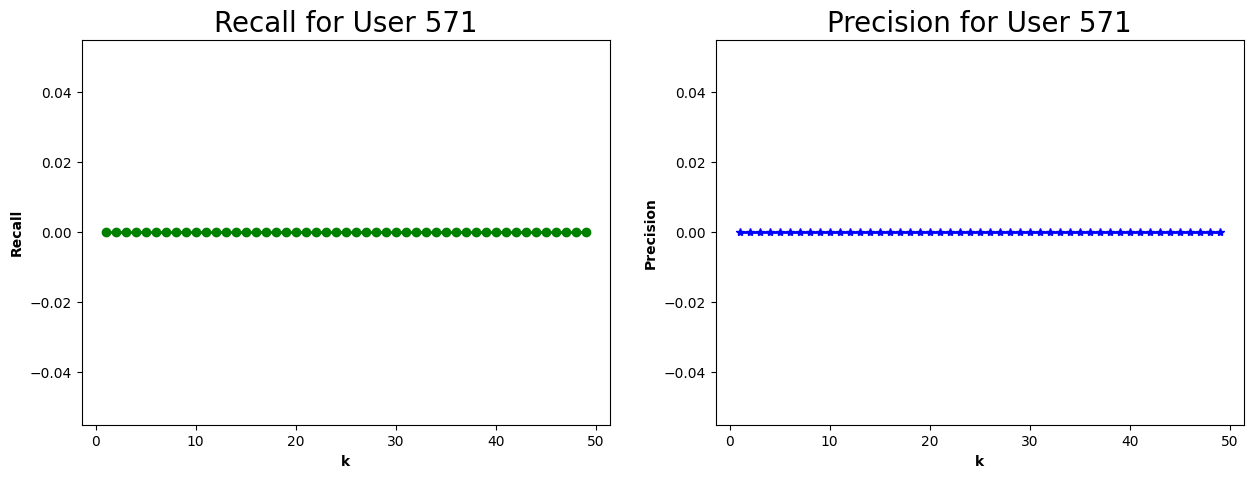

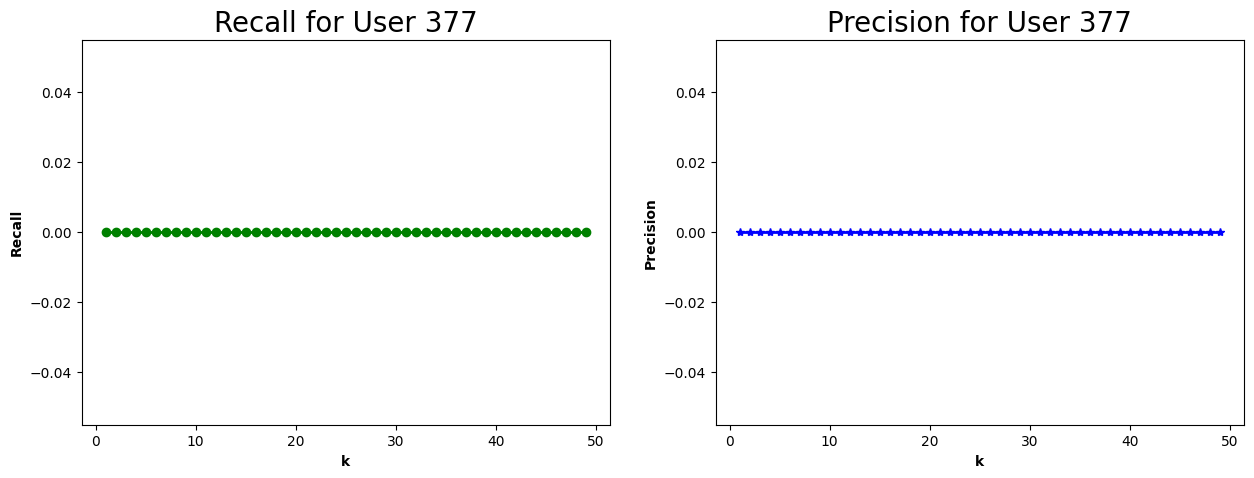

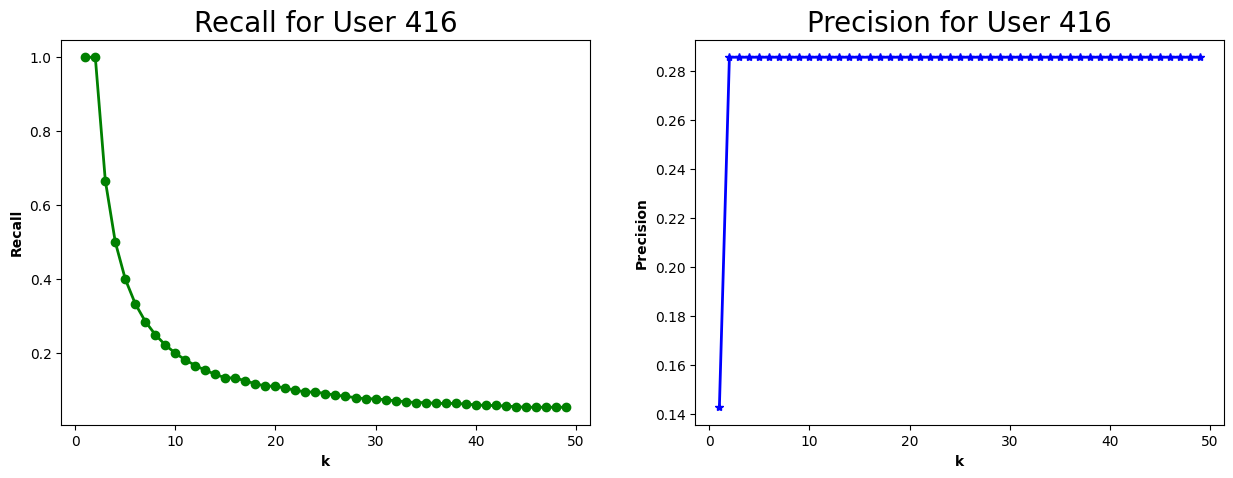

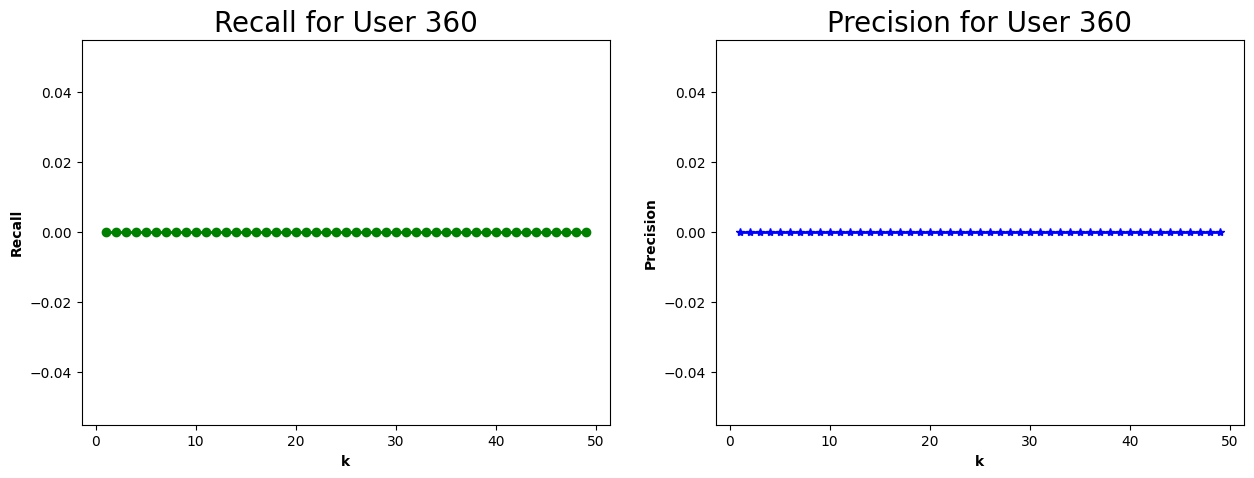

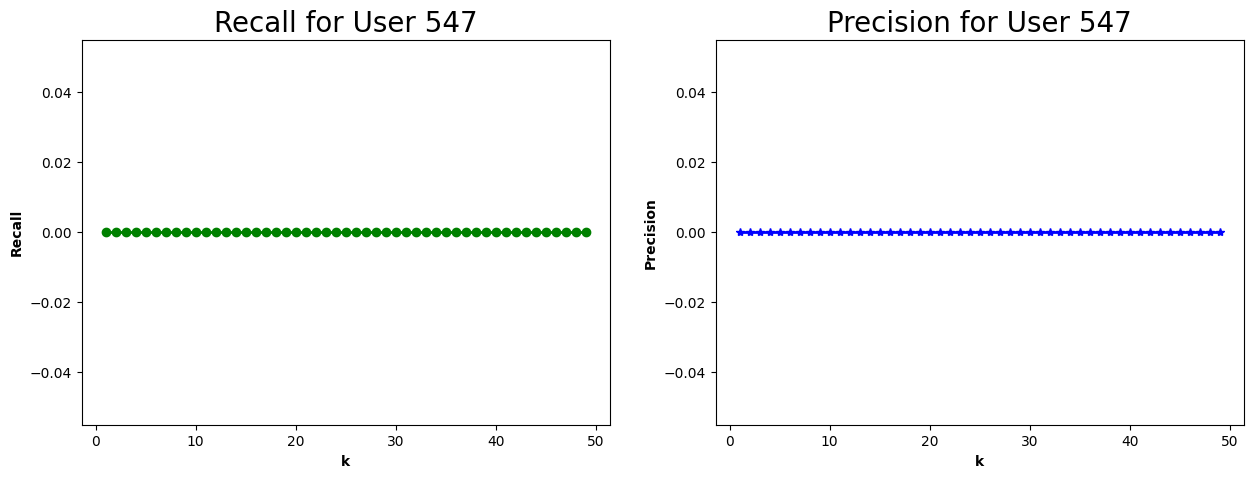

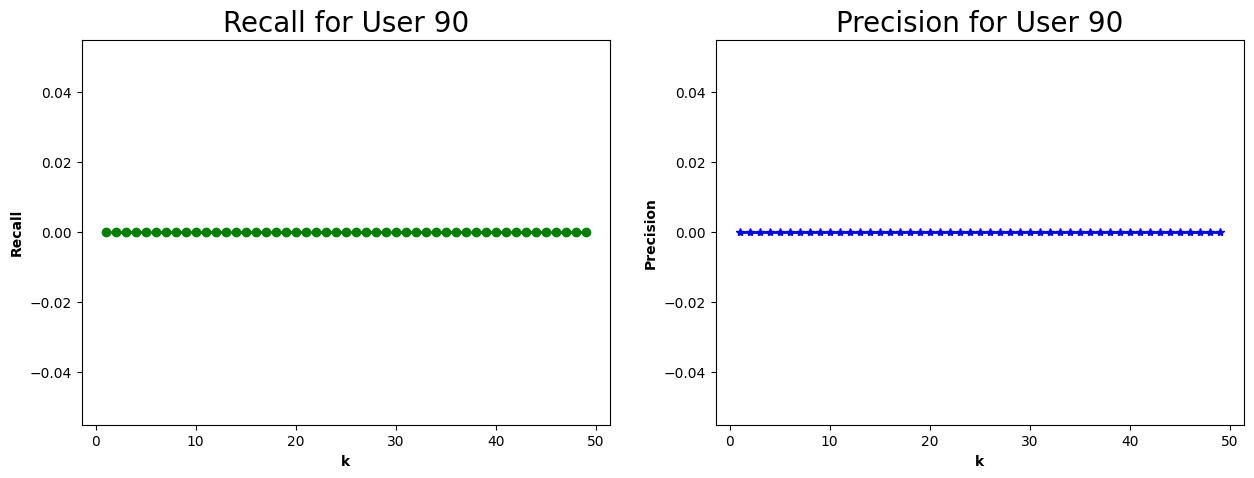

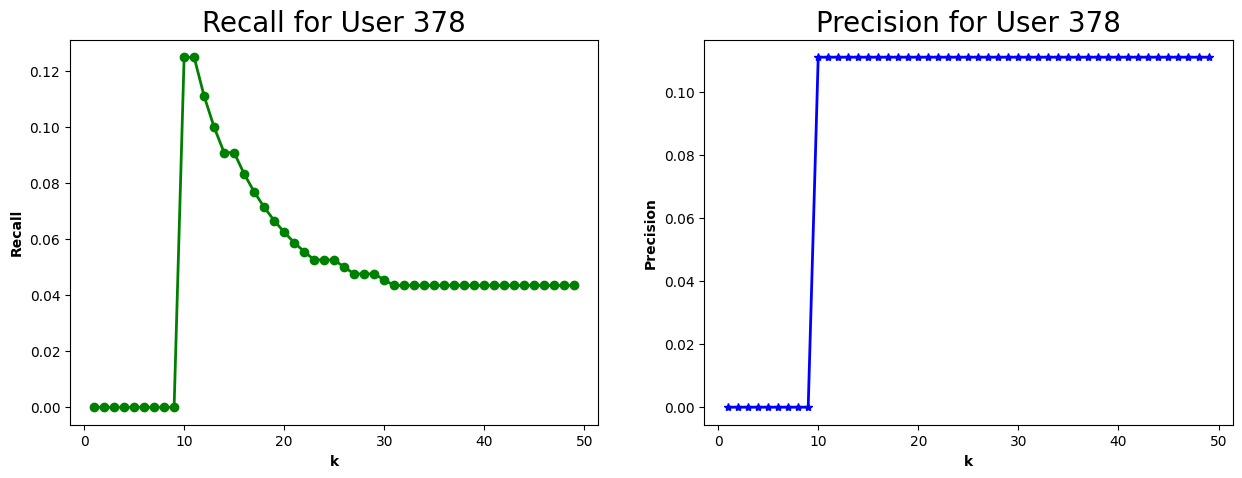

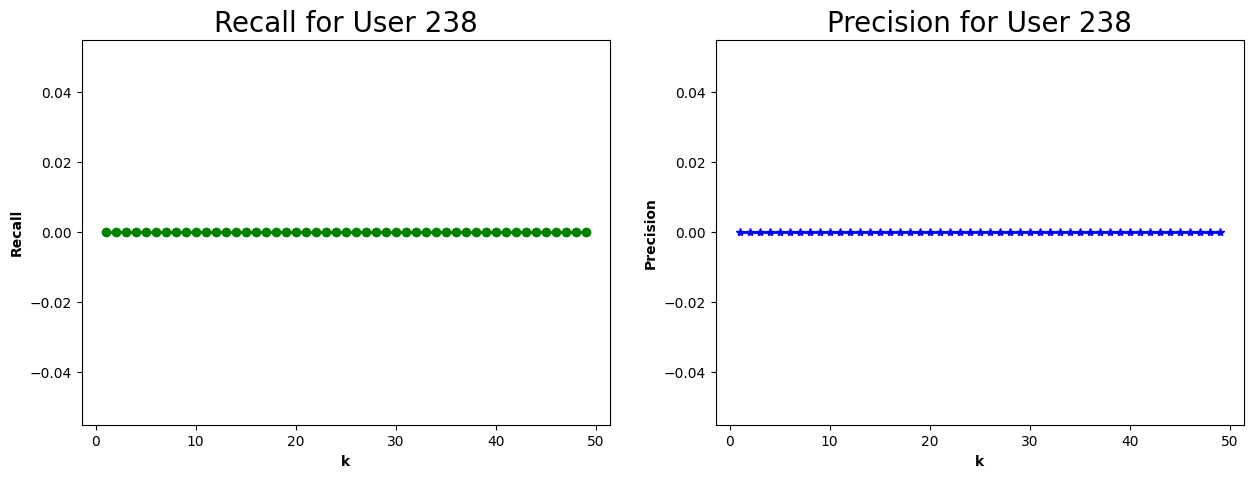

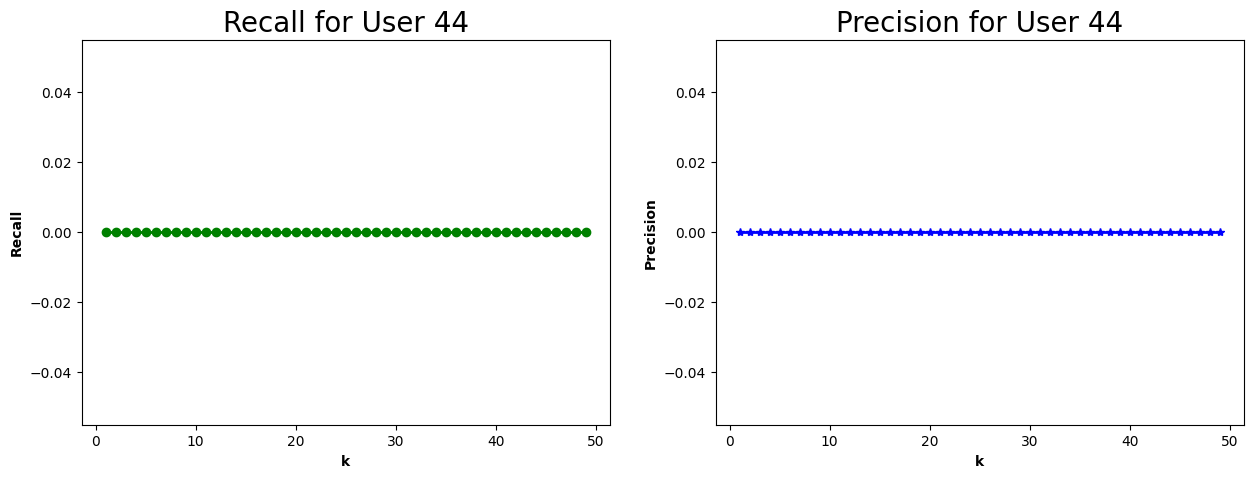

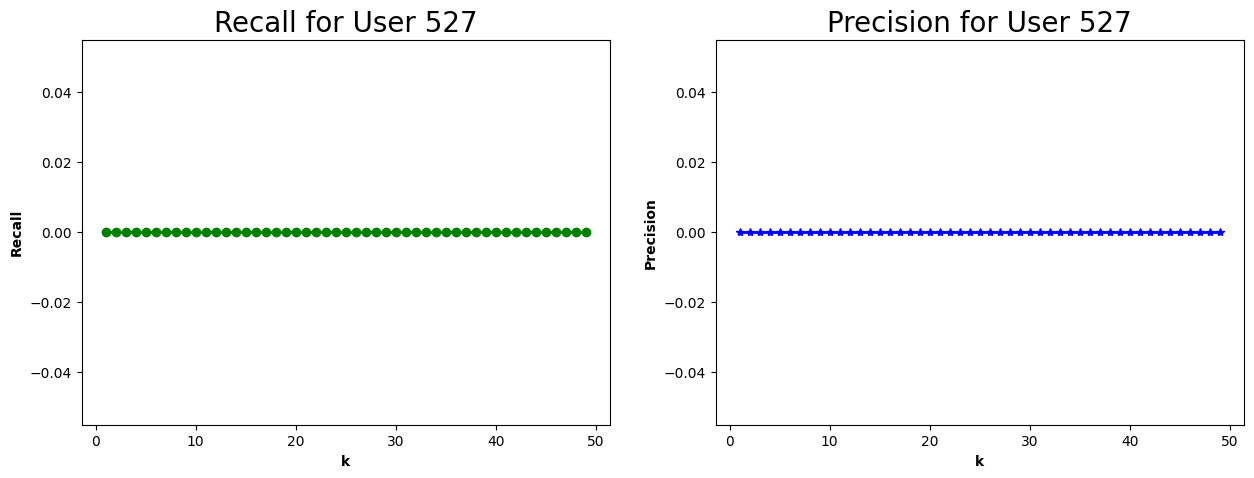

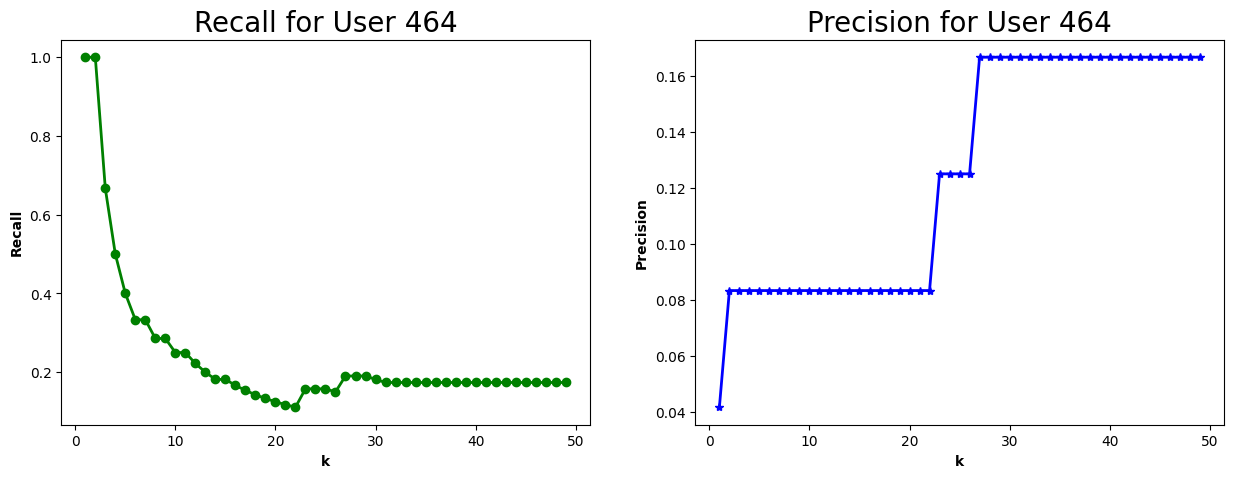

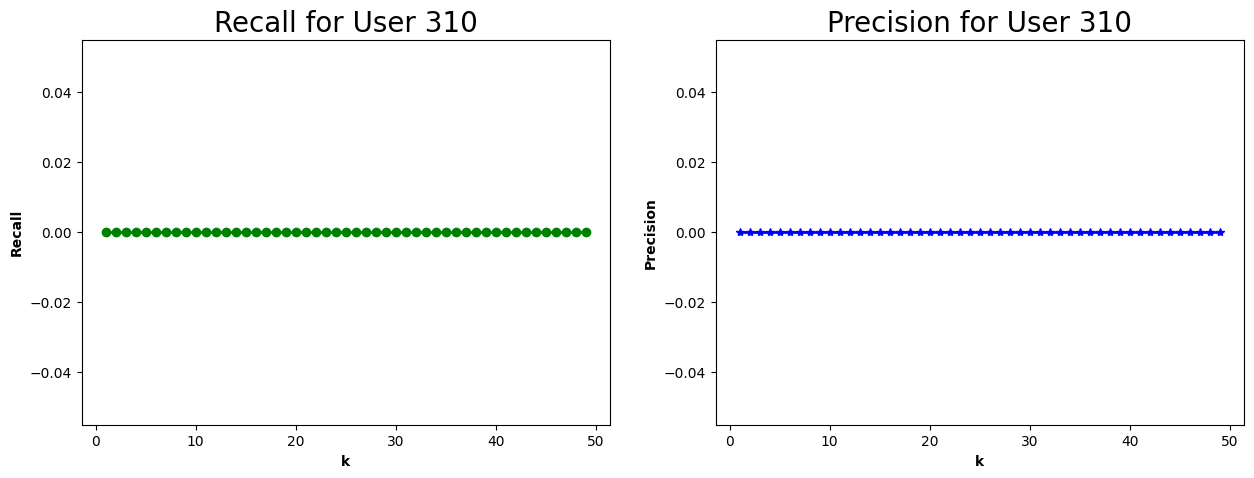

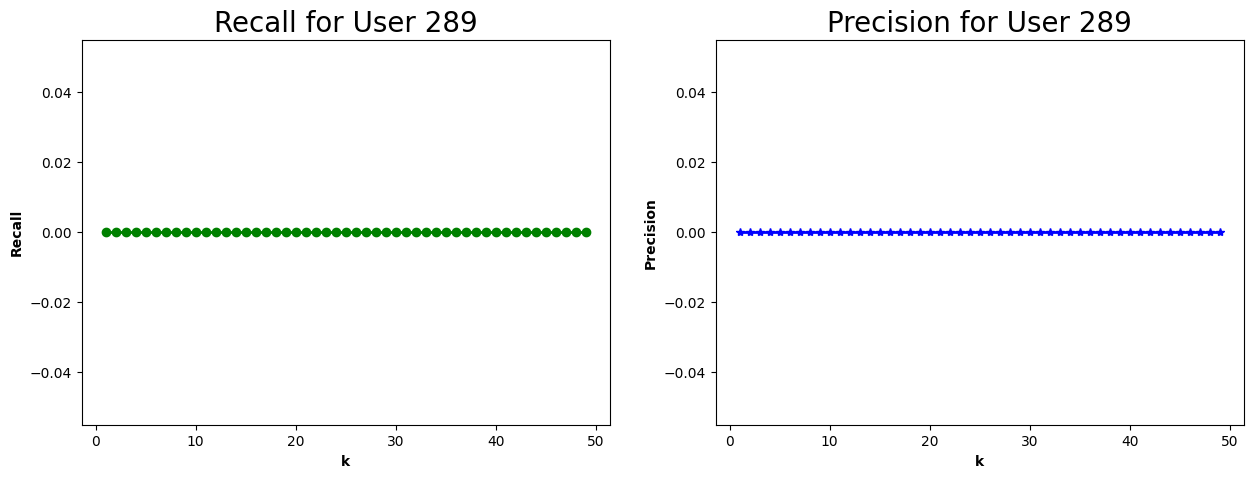

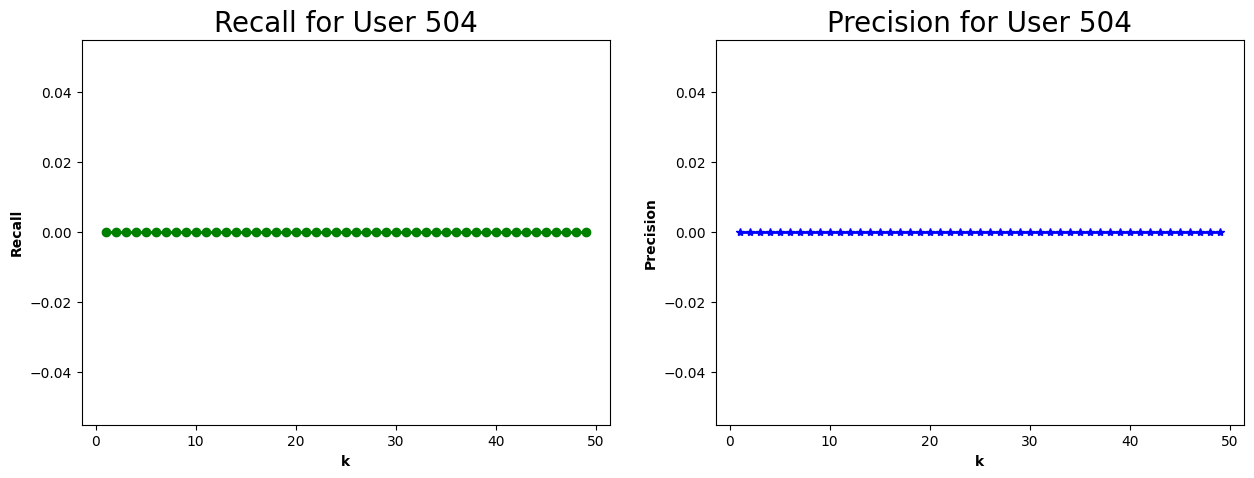

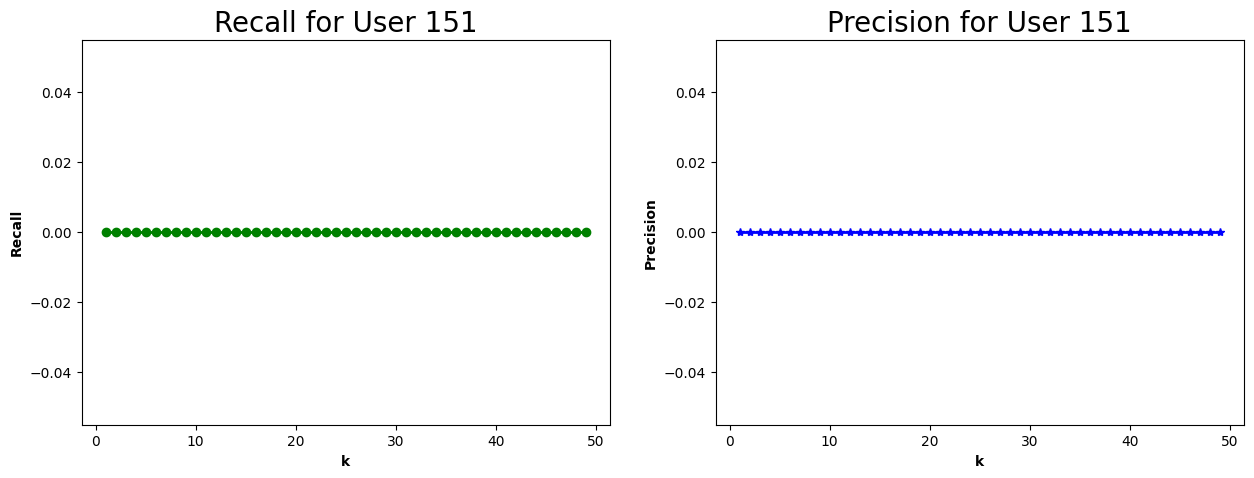

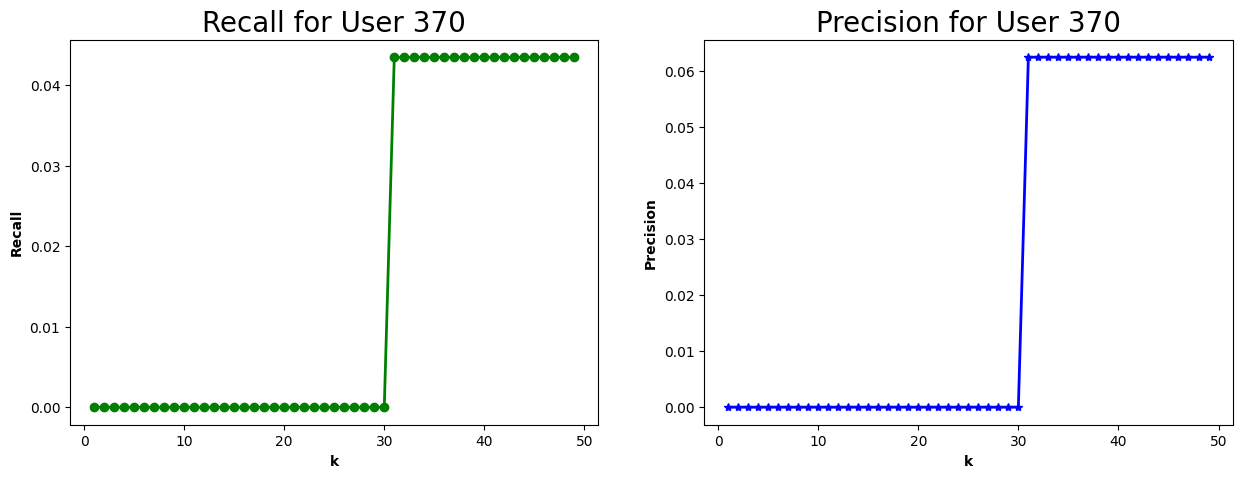

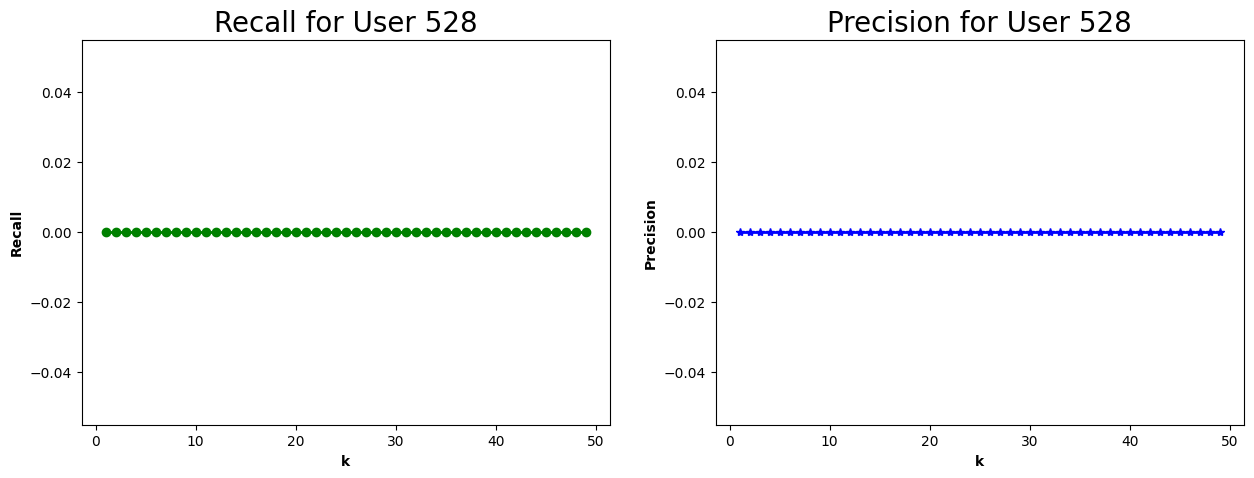

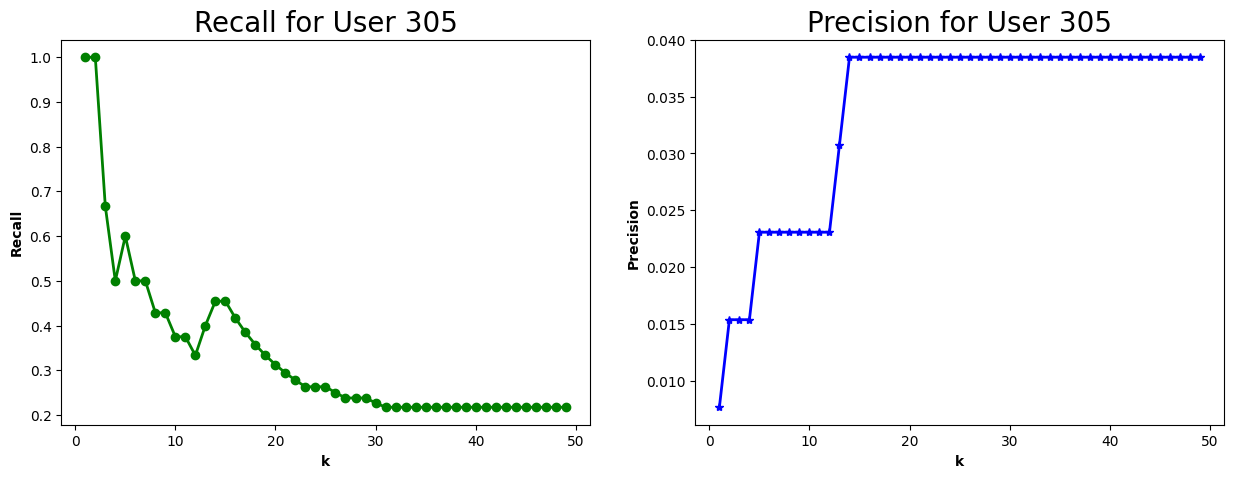

In [66]:
for i in random.sample(range(1,len(user)+1),25):
  figure, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
  ax1.plot(range(1,50), user[i]['recall'], 'go-', label='line 1', linewidth=2)
  ax1.set_ylabel('Recall',
                fontweight ='bold')
  ax1.set_xlabel('k',
                fontweight ='bold')

  ax1.set_title('Recall for User '+ str(user[i]['userId']), fontsize=20)
  ax2.plot(range(1,50), user[i]['precision'], 'b*-', label='line 1', linewidth=2)
  ax2.set_ylabel('Precision',
                fontweight ='bold')
  ax2.set_xlabel('k',
                fontweight ='bold')
  ax2.set_title('Precision for User '+str(user[i]['userId']), fontsize=20)